# 01: Sampling

This notebook locates and samples plots, exporting a GeoParquet file with LiDAR metrics and arrays of NAIP reflectance values for each plot.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import ee
import rasterio
import pandas as pd
from openlocationcode import openlocationcode

from naip_cnn import sampling

ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [4]:
N_SAMPLES = 15_000
MIN_SPACING = 150
FOOTPRINT_SIZE = (30, 30)
NAIP_YEAR = 2011

## Generate Sample Points

Our training data will be a set of points with 1) aggregated LiDAR attributes for prediction and 2) corresponding reflectance values from NAIP imagery. Points will be generated from the LiDAR data using a random subset of plots on a regularly spaced grid to ensure a minimum spacing.

Note: If we wanted to extract additional LiDAR metrics, we could simply add them below.

In [5]:
with rasterio.open("../data/Malheur_lidar_cancov.tif") as src:
    cancov = src.read(1)
    samples = sampling.generate_spaced_samples(raster=src, min_spacing=MIN_SPACING, n=N_SAMPLES)
    samples = sampling.extract_raster_at_points(raster=src, points=samples).rename(
        columns={"b1": "cancov"}
    )

We can compare the distribution of measured and sampled canopy cover values:

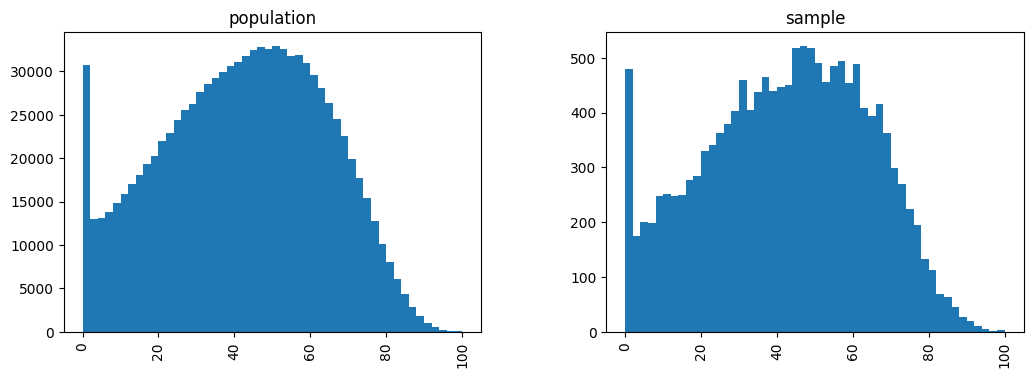

In [6]:
distribution = pd.concat(
    [
        samples[["cancov"]].assign(group="sample"),
        pd.DataFrame({"cancov": filter(lambda v: v == v, cancov.ravel())}).assign(
            group="population"
        ),
    ]
)

distribution.hist(by="group", bins=50, figsize=(12, 4));

We need a deterministic method for uniquely identifying our sample points so that we can potentially extract additional data in the future. We'll use [Plus Codes](https://maps.google.com/pluscodes/), which encode latitude and longitude coordinates into short strings.

In [7]:
samples["id"] = samples.to_crs("EPSG:4326").geometry.apply(
    lambda geom: openlocationcode.encode(geom.y, geom.x, 14)
)
samples.head()

,geometry,cancov,id
0,POINT (-1795635.934 2628435.394),38.642200,85P3M3PJ+M6RXHJ
1,POINT (-1825635.934 2639235.394),60.825901,85P2PM8H+9RR684
2,POINT (-1786485.934 2612685.394),71.614304,85P3H69R+H2HWXW
3,POINT (-1796685.934 2614035.394),71.079300,85P3H456+HCFHVH
4,POINT (-1784385.934 2636085.394),38.633999,85P3Q5HW+277W5X


Check to make sure each plot has a unique ID.

In [8]:
assert samples["id"].duplicated().sum() == 0

## Extract NAIP Chips

With our sample points defined, we can extract spectral data from the NAIP footprint overlapping each. First, we'll create a mosaic of NAIP imagery from the target year, covering our sample points.

In [9]:
proj = ee.Projection(src.crs.to_wkt())
bbox = ee.Geometry.BBox(*samples.to_crs("EPSG:4326").total_bounds)

naip_mosaic = (
    ee.ImageCollection("USDA/NAIP/DOQQ")
    .filterBounds(bbox)
    .filterDate(str(NAIP_YEAR), str(NAIP_YEAR + 1))
    .mosaic()
    .reproject(proj)
)

Now we can extract pixel values in the 30x30 footprint covering each sample point. This data is pulled from Earth Engine servers, so it may take a minute to extract. The `chunk_size` parameter is used to split the samples to avoid Earth Engine limits. Chunks are downloaded in parallel, so smaller sizes can yield faster downloads.

In [11]:
footprints = sampling.extract_footprints_from_dataframe(
    img=naip_mosaic,
    df=samples,
    dims=FOOTPRINT_SIZE,
    proj=proj,
    chunk_size=1000,
)

Now we can join the NAIP footprints to our original sample points. This will give us a dataframe of points with both LiDAR measurements and NAIP pixel values.

In [12]:
data = pd.merge(samples, footprints, on="id")
data.head()

,geometry,cancov,id,B,G,N,R
0,POINT (-1795635.934 2628435.394),38.642200,85P3M3PJ+M6RXHJ,"[131, 136, 129, 125, 120, 123, 133, 116, 101, ...","[153, 156, 149, 148, 145, 146, 154, 142, 133, ...","[174, 179, 175, 174, 172, 175, 180, 172, 165, ...","[145, 146, 143, 141, 140, 141, 144, 137, 127, ..."
1,POINT (-1825635.934 2639235.394),60.825901,85P2PM8H+9RR684,"[108, 114, 113, 120, 116, 101, 132, 132, 107, ...","[126, 130, 133, 137, 131, 119, 146, 147, 122, ...","[186, 188, 188, 191, 196, 185, 194, 198, 179, ...","[110, 119, 119, 121, 117, 106, 119, 126, 109, ..."
2,POINT (-1786485.934 2612685.394),71.614304,85P3H69R+H2HWXW,"[141, 141, 157, 78, 100, 109, 126, 85, 149, 15...","[164, 159, 171, 119, 136, 152, 165, 134, 184, ...","[201, 202, 206, 190, 197, 195, 206, 196, 209, ...","[171, 175, 180, 127, 140, 143, 158, 125, 169, ..."
3,POINT (-1796685.934 2614035.394),71.079300,85P3H456+HCFHVH,"[49, 49, 80, 112, 116, 96, 89, 32, 34, 52, 83,...","[58, 54, 84, 114, 115, 94, 88, 38, 36, 54, 79,...","[100, 100, 147, 172, 174, 158, 152, 73, 70, 82...","[50, 47, 73, 93, 97, 80, 74, 37, 36, 44, 63, 6..."
4,POINT (-1784385.934 2636085.394),38.633999,85P3Q5HW+277W5X,"[118, 109, 97, 75, 57, 96, 124, 114, 115, 114,...","[130, 120, 108, 88, 74, 113, 140, 138, 138, 14...","[190, 188, 185, 172, 164, 189, 197, 195, 195, ...","[109, 106, 97, 80, 74, 106, 129, 129, 131, 126..."


We can use the `preview_footprint` function to get an idea of what our footprints look like.

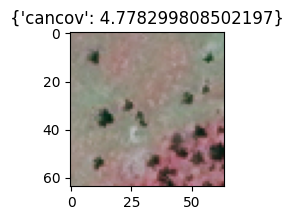

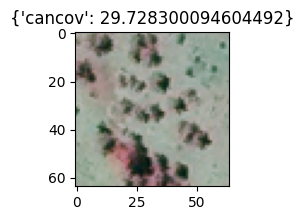

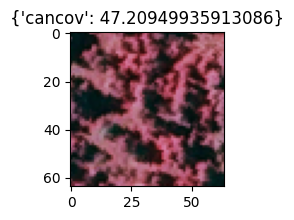

In [13]:
for _, footprint in data.sample(n=3).iterrows():
    sampling.preview_footprint(footprint, figsize=(2, 2), shape=(64, 64))

## Exporting

The final step is to export our sampled footprints so that we can access them during training. We'll store them in a [GeoParquet](https://geoparquet.org/) format, which allows similar compression to TFRecords with the accessibility of CSVs.

In [14]:
data.to_parquet("../data/malheur_footprints.parquet", compression="gzip")